# CAE

## Setup

In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
import pathlib
import random

tf.enable_eager_execution()

config = tf.ConfigProto()
config.gpu_options.allow_growth = True
session = tf.Session(config=config)
tf.keras.backend.set_session(session)

AUTOTUNE = tf.data.experimental.AUTOTUNE

## Load and split image paths

In [2]:
tagged_image_paths = list(pathlib.Path('./dataset/tiles-resized/').glob('*.jpg'))
untagged_image_paths = list(pathlib.Path('./dataset/extra-tiles-untagged/').glob('*.jpg'))
image_paths = [str(path) for path in (tagged_image_paths + untagged_image_paths)]
random.shuffle(image_paths)

# train-test split
dataset_size = len(image_paths)
train_size = int(dataset_size * 0.7)
val_size = int(dataset_size * 0.15)
test_size = dataset_size - train_size - val_size

train_paths = image_paths[:train_size]
val_paths = image_paths[train_size:train_size+val_size]
test_paths = image_paths[train_size+val_size:]

## Create datasets, preprocessing

Instructions for updating:
Colocations handled automatically by placer.
train size 4696
val size 1004
test size 1012


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


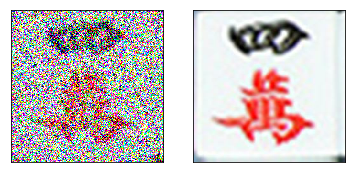

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


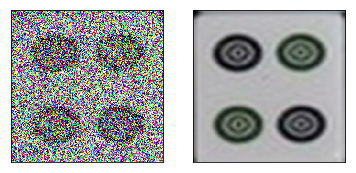

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


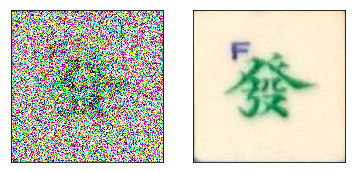

In [3]:
def show_noisy_image_sample(ds):
    for n, (noisy, orig) in enumerate(ds.take(3)):
        plt.subplot(1,2,1)
        plt.imshow(noisy)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.subplot(1,2,2)
        plt.imshow(orig)
        plt.grid(False)
        plt.xticks([])
        plt.yticks([])
        plt.show()

def read_image(path):
    image = tf.read_file(path)
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.image.resize_images(image, [320, 320])
    image /= 255.0 # normalize to [0,1]
    return image

def rotate_image(image):
    image = tf.image.rot90(image)
    return image
    
def add_noise_to_x(x, y):
    x += tf.random.normal(shape=x.shape, mean=0.0, stddev=1.0)
    return x, y

def get_dataset(paths):
    path_ds = tf.data.Dataset.from_tensor_slices(paths)
    image_ds = path_ds.map(read_image, num_parallel_calls=AUTOTUNE)
    image_ds_90 = image_ds.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds_180 = image_ds_90.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds_270 = image_ds_180.map(rotate_image, num_parallel_calls=AUTOTUNE)
    image_ds = image_ds.concatenate(image_ds_90).concatenate(image_ds_180).concatenate(image_ds_270)
    paired_ds = tf.data.Dataset.zip((image_ds, image_ds))
    paired_ds = paired_ds.map(map_func=add_noise_to_x, num_parallel_calls=AUTOTUNE)
    return paired_ds
    
train_ds = get_dataset(train_paths)
train_size *= 4
print('train size', train_size)
val_ds = get_dataset(val_paths)
val_size *= 4
print('val size', val_size)
test_ds = get_dataset(test_paths)
test_size *= 4
print('test size', test_size)

show_noisy_image_sample(test_ds)

## Train CAE Model

In [ ]:
batch_size = 32
# FIXME: use map_and_batch?
# FIXME: cpu bottleneck during data load, prefetch not working?
train_ds_batch = train_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=train_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)
val_ds_batch = val_ds.cache()\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=val_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

encoder = keras.Sequential(layers=[
    keras.layers.BatchNormalization(input_shape=(320,320,3)),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=3, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.MaxPool2D(pool_size=(2,2), strides=2),

    keras.layers.Conv2D(filters=16, kernel_size=3, strides=1, activation='selu'),
], name='encoder')

decoder = keras.Sequential(layers=[
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='selu', input_shape=(16,16,16)),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=2, strides=1, activation='selu'),
    keras.layers.Conv2DTranspose(filters=32, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=16, kernel_size=4, strides=2, activation='selu'),
    keras.layers.Conv2DTranspose(filters=3, kernel_size=3, strides=1, activation='sigmoid'),
], name='decoder')

cae = keras.Sequential([encoder, decoder])
cae.compile(optimizer='adam', loss='mean_squared_error', metrics=['accuracy'])

# encoder.summary()
# decoder.summary()
# cae.summary()

cae.fit(x=train_ds_batch,
        epochs=10,
        steps_per_epoch=int(train_size/batch_size),
        validation_data=val_ds_batch,
        validation_steps=int(val_size/batch_size),
        callbacks=[keras.callbacks.TensorBoard(log_dir='./logs')]
       )

Instructions for updating:
Use tf.cast instead.
Epoch 1/10


## Visualize Predictions

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


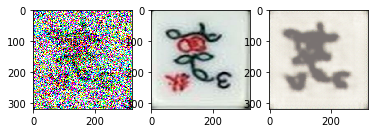

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


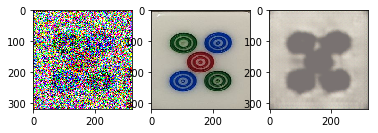

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


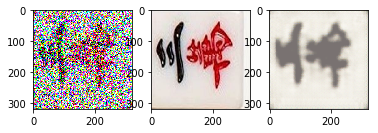

In [6]:
for n, (noisy, orig) in enumerate(val_ds.take(3)):
    plt.subplot(1,3,1)
    plt.imshow(noisy)
    plt.subplot(1,3,2)
    plt.imshow(orig)
    plt.subplot(1,3,3)
    pred = cae.predict_on_batch(x=noisy[np.newaxis,:])[0]
    plt.imshow(pred)
    plt.show()

## Test CAE Model

In [7]:
test_ds_batch = test_ds.cache(filename='./cache/test_ds_batch')\
    .apply(tf.data.experimental.shuffle_and_repeat(buffer_size=test_size))\
    .batch(batch_size)\
    .prefetch(buffer_size=AUTOTUNE)

cae.evaluate(x=test_ds_batch, steps=1)

1/1 [==============================] - 15s 15s/step - loss: 0.0220 - acc: 0.6566


[0.021998628973960876, 0.6565637]

## Save models

In [8]:
keras.models.save_model(
    model=encoder,
    filepath='./models/encoder.h5py',
    overwrite=True,
    include_optimizer=True
)

keras.models.save_model(
    model=decoder,
    filepath='./models/decoder.h5py',
    overwrite=True,
    include_optimizer=True
)